In [1]:
# for downloading datasets
import os
import urllib.request
import gzip, shutil
from tensorflow.keras.utils import get_file
import h5py
# snn torch
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import utils
# torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
# for plotting and iterating data
import matplotlib.pyplot as plt
import numpy as np
import tables

## Spilking Heidelberg Digits Dataset

Found at https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/

In [3]:
# First download the files
cache_dir=os.path.expanduser("~/data")
cache_subdir="hdspikes"
print("Using cache dir: %s"%cache_dir)
# The remote directory with the data files
base_url = "https://zenkelab.org/datasets"
# Retrieve MD5 hashes from remote
response = urllib.request.urlopen("%s/md5sums.txt"%base_url)
data = response.read() 
lines = data.decode('utf-8').split("\n")
file_hashes = { line.split()[1]:line.split()[0] for line in lines if len(line.split())==2 }
def get_and_gunzip(origin, filename, md5hash=None):
    gz_file_path = get_file(filename, origin, md5_hash=md5hash, cache_dir=cache_dir, cache_subdir=cache_subdir)
    hdf5_file_path=gz_file_path[:-3]
    if not os.path.isfile(hdf5_file_path) or os.path.getctime(gz_file_path) > os.path.getctime(hdf5_file_path):
        print("Decompressing %s"%gz_file_path)
        with gzip.open(gz_file_path, 'r') as f_in, open(hdf5_file_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    return hdf5_file_path


Using cache dir: /Users/amrita/data


In [4]:
# Download the Spiking Heidelberg Digits (SHD) dataset
origin = "%s/%s"%(base_url,"shd_train.h5.gz")
train_file_path = get_and_gunzip(origin, "shd_train.h5.gz", md5hash=file_hashes["shd_train.h5.gz"])
print(train_file_path)

origin = "%s/%s"%(base_url,"shd_test.h5.gz")
test_file_path = get_and_gunzip(origin, "shd_test.h5.gz", md5hash=file_hashes["shd_test.h5.gz"])
print(test_file_path)

/tmp/.keras/hdspikes/shd_train.h5
/tmp/.keras/hdspikes/shd_test.h5


Times (ms): [0.       0.001625 0.001625 ... 0.7285   0.7305   0.7305  ]
Unit IDs: [172 680 698 ... 515 664 277]
Label: 10


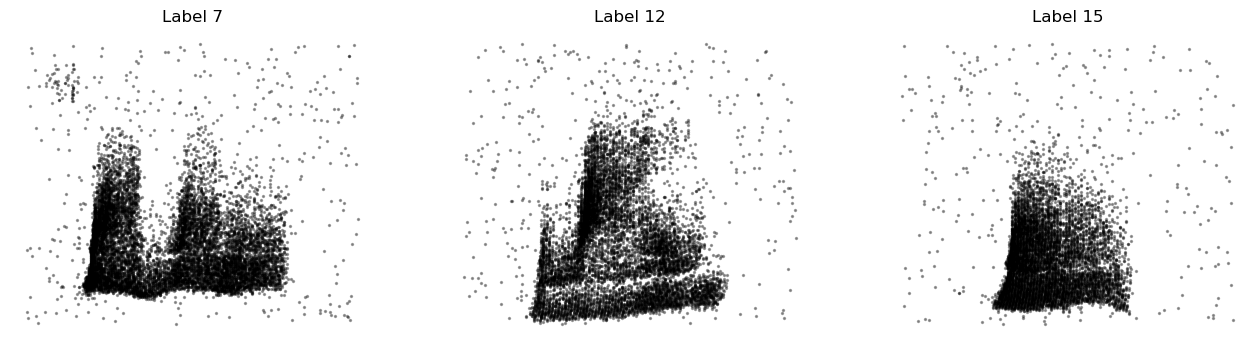

In [5]:
# Visualize the data
fileh = tables.open_file(test_file_path, mode='r')
units = fileh.root.spikes.units
times = fileh.root.spikes.times
labels = fileh.root.labels
# This is how we access spikes and labels
index = 0
print("Times (ms):", times[index])
print("Unit IDs:", units[index])
print("Label:", labels[index])
# A quick raster plot for one of the samples
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,4))
idx = np.random.randint(len(times),size=3)
for i,k in enumerate(idx):
    ax = plt.subplot(1,3,i+1)
    ax.scatter(times[k],700-units[k], color="k", alpha=0.33, s=2)
    ax.set_title("Label %i"%labels[k])
    ax.axis("off")
plt.show()

# Setting up the Dataset for Training
The SHD datasets are provided in the HDF5 format. This is the structure: <br>
root <br>
|-spikes <br>
&emsp;   |-times[] <br>
 &emsp;  |-units[] <br>
|-labels[] <br>
|-extra <br>
 &emsp;  |-speaker[] <br>
 &emsp;  |-keys[] <br>
  &emsp; |-meta_info <br>
   &emsp;  &emsp; |-gender[] <br>
   &emsp;  &emsp; |-age[] <br>
   &emsp;  &emsp; |-body_height[] <br>
<br>
For iterating through the data, we will be accessing the spikes and labels.


In [6]:
# This sets up the dataset so it can be iterated by DataLoader
class HDF5Dataset(Dataset):
    def __init__(self, file_path, num_inputs):
        self.file_path = file_path
        self.num = num_inputs
        self.fileh = h5py.File(file_path, 'r')
        self.units = self.fileh['spikes']['units']
        self.labels = self.fileh['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        unit_data = torch.tensor(self.units[index], dtype=torch.float32)
        label = torch.tensor(self.labels[index], dtype=torch.long)

        # change size as needed
        # it matches size in num_inputs
        target_length = self.num
        if unit_data.size(0) < target_length:
            pad_length_unit = target_length - unit_data.size(0)
            unit_data = torch.nn.functional.pad(unit_data, (0, pad_length_unit), mode='constant', value=0)
        elif unit_data.size(0) > target_length:
            unit_data = unit_data[:target_length]
        
        return unit_data, label

In [7]:
# referenced https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial4.ipynb
# Network Architecture Parameters
num_inputs = 700
num_hidden = 1000
num_outputs = 20
batch_size = 128

num_steps = 25

In [8]:
# Torch Variables
dtype = torch.float
# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [9]:
# Set up train and test sets
train_dataset = HDF5Dataset(train_file_path, num_inputs)
test_dataset = HDF5Dataset(test_file_path, num_inputs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
# Define Network
weight_scale = 0.2
beta = 0.9

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(beta=beta)

        # Custom weight initialization
        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=weight_scale / np.sqrt(num_inputs))
        torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=weight_scale / np.sqrt(num_hidden))
        
        torch.nn.init.normal_(self.fc3.weight, mean=0.0, std=weight_scale / np.sqrt(num_hidden))

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

In [11]:
# Functions for printing accuracy
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [12]:
# Set up loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(net.parameters(), lr=3e-4, betas=(0.7, 0.71))

# One Iteration of Training

In [13]:
# Take the first batch of data and load it onto CUDA
data, targets = next(iter(train_loader))
data = data.to(device)
print(data.shape)
targets = targets.to(device)

torch.Size([128, 700])


In [14]:
# Flatten the input data and pass it into the network.
spk_rec, mem_rec = net(data.view(batch_size, -1))
print(mem_rec.size())

torch.Size([25, 128, 20])


The recording of the membrane potential is taken across:
* 100 time steps
* 128 samples of data
* 20 output neurons

We wish to calculate the loss at every time step, and sum these up together, as per Equation $(10)$:

In [15]:
# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 75.283
Train set accuracy for a single minibatch: 7.81%


The loss is quite large, because it is summed over 25 time steps. The accuracy is also bad as the network is untrained:

In [16]:
# clear previously stored gradients
optimizer.zero_grad()

# calculate the gradients
loss_val.backward()

# weight update
optimizer.step()

In [17]:
# calculate new network outputs using the same data
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initialize the total loss value
loss_val = torch.zeros((1), dtype=dtype, device=device)

# sum loss at every step
for step in range(num_steps):
  loss_val += loss(mem_rec[step], targets)

print(f"Training loss: {loss_val.item():.3f}")
print_batch_accuracy(data, targets, train=True)

Training loss: 74.250
Train set accuracy for a single minibatch: 7.81%


# Training Loop

In [27]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(net.parameters(), lr=1e-4, betas=(0.7, 0.81))

In [30]:
num_epochs = 5
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(
                    data, targets, epoch,
                    counter, iter_counter,
                    loss_hist, test_loss_hist,
                    test_data, test_targets)
            counter += 1
            iter_counter +=1

Epoch 0, Iteration 0
Train Set Loss: 65.48
Test Set Loss: 66.17
Train set accuracy for a single minibatch: 8.59%
Test set accuracy for a single minibatch: 9.38%


Epoch 0, Iteration 50
Train Set Loss: 66.31
Test Set Loss: 67.02
Train set accuracy for a single minibatch: 5.47%
Test set accuracy for a single minibatch: 3.91%


Epoch 1, Iteration 37
Train Set Loss: 62.73
Test Set Loss: 64.10
Train set accuracy for a single minibatch: 9.38%
Test set accuracy for a single minibatch: 2.34%


Epoch 2, Iteration 24
Train Set Loss: 65.23
Test Set Loss: 64.96
Train set accuracy for a single minibatch: 7.03%
Test set accuracy for a single minibatch: 12.50%


Epoch 3, Iteration 11
Train Set Loss: 65.66
Test Set Loss: 66.60
Train set accuracy for a single minibatch: 7.81%
Test set accuracy for a single minibatch: 8.59%


Epoch 3, Iteration 61
Train Set Loss: 63.36
Test Set Loss: 65.79
Train set accuracy for a single minibatch: 10.94%
Test set accuracy for a single minibatch: 10.16%


Epoch 4, Itera

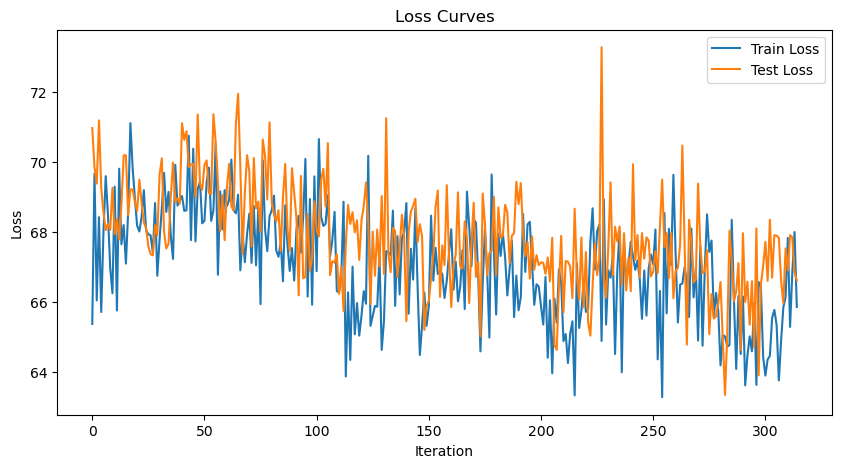

In [29]:
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [138]:
total = 0
correct = 0

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 214/2264
Test Set Accuracy: 9.45%
